## Reusable Website Categorization Neural Network Model (NLP)
#### This notebooks provide step by step guide to process the data, train the model, fine tune, evaluate and model transfer/reuse

To make the website categorization more robust and accurate, I've decided to build a transformer model which can be integrated in any such similar project. This is basically a NLP Model trained on 1400 different website's metadata.

This model will help us classify different websites on keyword pattern used in the website metadata.


### A traditional web scrapping technique could be chosen instead of jumping into NN.
### But I prefer this so that it can be reused to make our work easier in our further similar projects.
#### Process was carried out on Google Colab.

### Init G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from wordcloud import WordCloud
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Load Data

In [3]:
data = pd.read_csv("./drive/MyDrive/model_train/website_classification.csv", sep=",")

In [4]:
data.head()

Unnamed: 0                                        website_url  \
0           0     https://www.booking.com/index.html?aid=1743217   
1           1                   https://travelsites.com/expedia/   
2           2               https://travelsites.com/tripadvisor/   
3           3              https://www.momondo.in/?ispredir=true   
4           4  https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...   

                                cleaned_website_text Category  
0  official site good hotel accommodation big sav...   Travel  
1  expedia hotel book sites like use vacation wor...   Travel  
2  tripadvisor hotel book sites like previously d...   Travel  
3  cheap flights search compare flights momondo f...   Travel  
4  bot create free account create free account si...   Travel

In [5]:
data.isnull().sum()

Unnamed: 0              0
website_url             0
cleaned_website_text    0
Category                0
dtype: int64

In [6]:
data.shape

(1408, 4)

In [7]:
class_dist = data['Category'].value_counts()

In [ ]:
class_dist

Category
Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


## Sample selection based on classes

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
# Load your dataset into 'data' DataFrame with 'cleaned_website_text' and 'Category' columns

# Separate features and target variable
X = data.drop('Category', axis=1)  # Features
y = data['Category']  # Target variable

# Perform oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)

# Perform undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)


In [ ]:
X_over

Unnamed: 0                                        website_url  \
0              0     https://www.booking.com/index.html?aid=1743217   
1              1                   https://travelsites.com/expedia/   
2              2               https://travelsites.com/tripadvisor/   
3              3              https://www.momondo.in/?ispredir=true   
4              4  https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...   
...          ...                                                ...   
1819          32  https://www.viceroyhotelsandresorts.com/los-cabos   
1820          68  https://www.jumeirah.com/en/stay/dubai/burj-al...   
1821          17                      https://www.costcotravel.com/   
1822          24                          https://fogoislandinn.ca/   
1823         571                              https://timespek.com/   

                                   cleaned_website_text  
0     official site good hotel accommodation big sav...  
1     expedia hotel book sites like use vacation wor...  
2     tripadvisor hotel book sites like previously d...  
3     cheap flights search compare flights momondo f...  
4     bot create free account create free account si...  
...                                                 ...  
1819  los cabos luxury resort viceroy los cabos sea ...  
1820  burj al arab dubai iconic hotel jumeirah welco...  
1821  home costco travel costco travel offer everyda...  
1822  home fogo island inn fogo island inn island is...  
1823  timespek observe infinity timespek multi platf...  

[1824 rows x 3 columns]

In [ ]:
data.describe().T

count   mean         std  min     25%    50%      75%     max
Unnamed: 0  1408.0  703.5  406.598901  0.0  351.75  703.5  1055.25  1407.0

In [ ]:
data.head(10)

Unnamed: 0                                        website_url  \
0           0     https://www.booking.com/index.html?aid=1743217   
1           1                   https://travelsites.com/expedia/   
2           2               https://travelsites.com/tripadvisor/   
3           3              https://www.momondo.in/?ispredir=true   
4           4  https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...   
5           5  https://book.priceline.com/?refid=8431&refclic...   
6           6  https://www.trip.com/index?locale=en_us&allian...   
7           7                            https://www.orbitz.com/   
8           8                       https://www.travelocity.com/   
9           9                           https://www.hotwire.com/   

                                cleaned_website_text Category  
0  official site good hotel accommodation big sav...   Travel  
1  expedia hotel book sites like use vacation wor...   Travel  
2  tripadvisor hotel book sites like previously d...   Travel  
3  cheap flights search compare flights momondo f...   Travel  
4  bot create free account create free account si...   Travel  
5  hotel reservations bundle save book flight sal...   Travel  
6  official travel deals promotion choose million...   Travel  
7  bot create free account create free account si...   Travel  
8  bot create free account create free account si...   Travel  
9  cheap hotels cars flights minute travel deals ...   Travel

## EDA // Visualization for error check

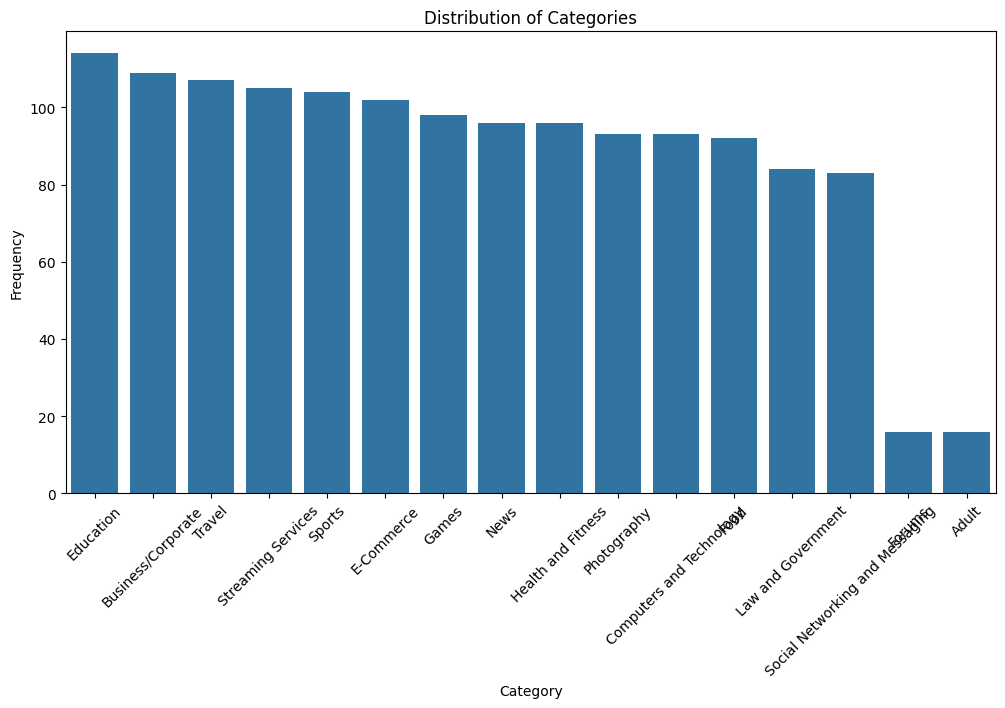

In [8]:
# Plot the distribution of categories
plt.figure(figsize=(12, 6))
sb.countplot(x='Category', data=data, order=data['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

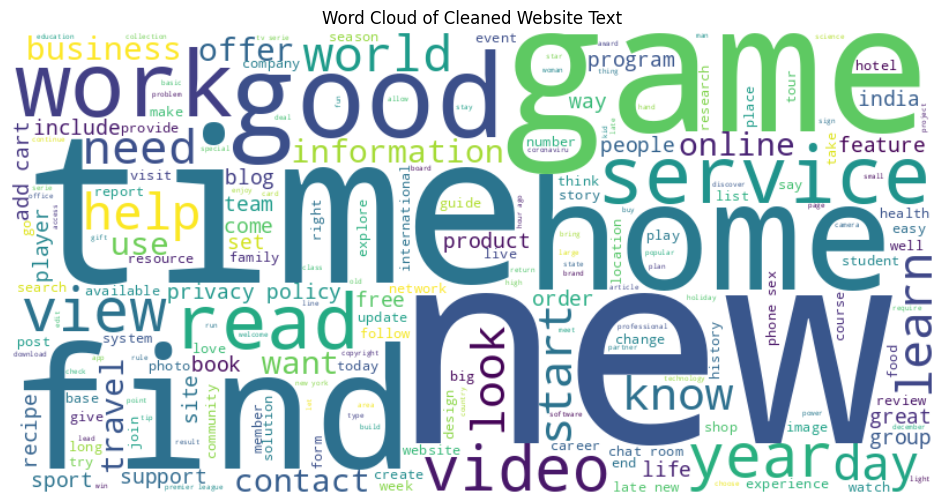

In [ ]:
# Combine all cleaned website text into a single string
text = ' '.join(data['cleaned_website_text'].values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Cleaned Website Text')
plt.axis('off')
plt.show()

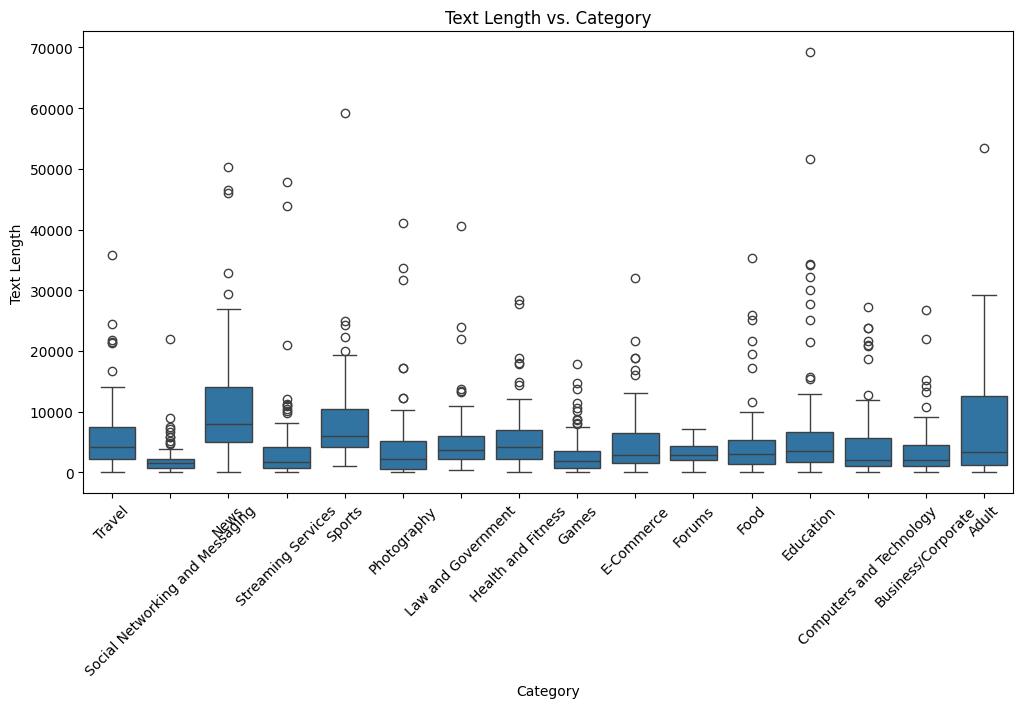

In [ ]:
# Add a new column to the DataFrame containing the length of the cleaned website text
data['text_length'] = data['cleaned_website_text'].apply(len)

# Plot the distribution of text lengths for each category
plt.figure(figsize=(12, 6))
sb.boxplot(x='Category', y='text_length', data=data)
plt.title('Text Length vs. Category')
plt.xlabel('Category')
plt.ylabel('Text Length')
plt.xticks(rotation=45)
plt.show()

## Tokenizing the cleaned website text (This might a bit long to execute as it does some sort of sracmble operation on the keywrods)

In [ ]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the cleaned website text
data['tokens'] = data['cleaned_website_text'].apply(word_tokenize)

# Function to count word frequency for each category
def count_word_frequency(tokens):
    word_counts = Counter(tokens)
    return word_counts

# Calculate word frequency for each category
def aggregate_word_counts(group):
    aggregated_counts = Counter()
    for tokens in group:
        if isinstance(tokens, list):
            aggregated_counts.update(tokens)
    return aggregated_counts

# Apply aggregation of word counts
category_word_frequency = data.groupby('Category')['tokens'].apply(aggregate_word_counts)

# Add debugging to check types and contents
print("Type of category_word_frequency:", type(category_word_frequency))
for category, word_freq in category_word_frequency.items():
    print(f"Category: {category}, Type of word_freq: {type(word_freq)}")

# Number of top words to visualize
N = 10

# Save the output to a text file instead of printing it
with open("top_words_per_category.txt", "w", encoding="utf-8") as file:
    for category, word_freq in category_word_frequency.items():
        if isinstance(word_freq, Counter):
            file.write(f"Category: {category}\n")
            top_words = word_freq.most_common(N)
            file.write(f"{top_words}\n\n")
        else:
            file.write(f"Category: {category} has invalid word frequency data.\n\n")

print("Top words per category saved to top_words_per_category.txt")


Streaming output truncated to the last 5000 lines.
Category: ('Adult', 'sotho'), Type of word_freq: <class 'float'>
Category: ('Adult', 'moraba'), Type of word_freq: <class 'float'>
Category: ('Adult', 'raba'), Type of word_freq: <class 'float'>
Category: ('Adult', 'pebble'), Type of word_freq: <class 'float'>
Category: ('Adult', 'remade'), Type of word_freq: <class 'float'>
Category: ('Adult', 'wargames'), Type of word_freq: <class 'float'>
Category: ('Adult', 'mssa'), Type of word_freq: <class 'float'>
Category: ('Adult', 'confederation'), Type of word_freq: <class 'float'>
Category: ('Adult', 'sascoc'), Type of word_freq: <class 'float'>
Category: ('Adult', 'epsom'), Type of word_freq: <class 'float'>
Category: ('Adult', 'magabotse'), Type of word_freq: <class 'float'>
Category: ('Adult', 'edwardian'), Type of word_freq: <class 'float'>
Category: ('Adult', 'johannesburg'), Type of word_freq: <class 'float'>
Category: ('Adult', 'amos'), Type of word_freq: <class 'float'>
Category: ('

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Computers and Technology', 'valued'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'customers'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'memberships'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'bank'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'schools'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'navigational'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'assistance'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'setting'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'scheduling'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'payment'), Type of word_freq: <class 'float'>
Category: ('Computers and Technology', 'fulfillment'), Type of word_freq: <c

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('E-Commerce', 'fao'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'epizooties'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'oie'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'woking'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'gu24'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', '0nf'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'rasayana'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'vajikaran'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'panchakarma'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'researches'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'chakrapani'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'squibb'), Type of word_freq: <class 'float'>
Category: ('E-Commerce', 'hiv'), Type of word_freq: <class 'float'>
Category: ('E-Comm

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Education', 'cabos'), Type of word_freq: <class 'float'>
Category: ('Education', 'fairmont'), Type of word_freq: <class 'float'>
Category: ('Education', 'kea'), Type of word_freq: <class 'float'>
Category: ('Education', 'lani'), Type of word_freq: <class 'float'>
Category: ('Education', 'ihg'), Type of word_freq: <class 'float'>
Category: ('Education', 'waikoloa'), Type of word_freq: <class 'float'>
Category: ('Education', 'xcaret'), Type of word_freq: <class 'float'>
Category: ('Education', 'scottsdale'), Type of word_freq: <class 'float'>
Category: ('Education', 'venetian'), Type of word_freq: <class 'float'>
Category: ('Education', 'shipboard'), Type of word_freq: <class 'float'>
Category: ('Education', 'orkney'), Type of word_freq: <class 'float'>
Category: ('Education', 'stirrup'), Type of word_freq: <class 'float'>
Category: ('Education', 'loews'), Type of word_freq: <class 'float'>
Category: ('Education', 'portofino'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Forums', 'freddy'), Type of word_freq: <class 'float'>
Category: ('Forums', 'elm'), Type of word_freq: <class 'float'>
Category: ('Forums', 'funhouse'), Type of word_freq: <class 'float'>
Category: ('Forums', 'genie'), Type of word_freq: <class 'float'>
Category: ('Forums', 'gilligan'), Type of word_freq: <class 'float'>
Category: ('Forums', 'gladiators'), Type of word_freq: <class 'float'>
Category: ('Forums', 'godzilla'), Type of word_freq: <class 'float'>
Category: ('Forums', 'goldeneye'), Type of word_freq: <class 'float'>
Category: ('Forums', 'gorgar'), Type of word_freq: <class 'float'>
Category: ('Forums', 'gators'), Type of word_freq: <class 'float'>
Category: ('Forums', 'hardbody'), Type of word_freq: <class 'float'>
Category: ('Forums', 'globetrotters'), Type of word_freq: <class 'float'>
Category: ('Forums', 'harley'), Type of word_freq: <class 'float'>
Category: ('Forums', 'haunted'), Type of word_freq: <class '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Forums', 'nilesh'), Type of word_freq: <class 'float'>
Category: ('Forums', 'sangoi'), Type of word_freq: <class 'float'>
Category: ('Forums', 'amarnath'), Type of word_freq: <class 'float'>
Category: ('Forums', 'ayub'), Type of word_freq: <class 'float'>
Category: ('Forums', 'azim'), Type of word_freq: <class 'float'>
Category: ('Forums', 'harshada'), Type of word_freq: <class 'float'>
Category: ('Forums', 'panvel'), Type of word_freq: <class 'float'>
Category: ('Forums', 'jairam'), Type of word_freq: <class 'float'>
Category: ('Forums', 'saindane'), Type of word_freq: <class 'float'>
Category: ('Forums', 'chitnis'), Type of word_freq: <class 'float'>
Category: ('Forums', 'chauffer'), Type of word_freq: <class 'float'>
Category: ('Forums', 'ranjith'), Type of word_freq: <class 'float'>
Category: ('Forums', 'subramanyam'), Type of word_freq: <class 'float'>
Category: ('Forums', 'carzonrent'), Type of word_freq: <class 'floa

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Games', 'sushant'), Type of word_freq: <class 'float'>
Category: ('Games', 'dil'), Type of word_freq: <class 'float'>
Category: ('Games', 'bechara'), Type of word_freq: <class 'float'>
Category: ('Games', 'scarface'), Type of word_freq: <class 'float'>
Category: ('Games', 'pacino'), Type of word_freq: <class 'float'>
Category: ('Games', 'tagdiv'), Type of word_freq: <class 'float'>
Category: ('Games', 'suresource24'), Type of word_freq: <class 'float'>
Category: ('Games', 'buruji'), Type of word_freq: <class 'float'>
Category: ('Games', 'kashamu'), Type of word_freq: <class 'float'>
Category: ('Games', 'tochi'), Type of word_freq: <class 'float'>
Category: ('Games', 'evict'), Type of word_freq: <class 'float'>
Category: ('Games', 'shaibu'), Type of word_freq: <class 'float'>
Category: ('Games', 'revolutionnow'), Type of word_freq: <class 'float'>
Category: ('Games', 'convener'), Type of word_freq: <class 'float'>
Category: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Health and Fitness', 'apratim'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'darryl'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'farewells'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'somber'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'indrasish'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'ganguly'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'aaditya'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'krishnamurthy'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'sourabh'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'squared'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'shwetang'), Type of word_freq: <class 'float'>
Category: ('Health and Fitness', 'parthsarthy'), Type of wor

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Law and Government', 'deseo'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'mágica'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'famosa'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'reportera'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'transportada'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'glamur'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'sencillos'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'placere'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'pueblerina'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'encuentra'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'felicidad'), Type of word_freq: <class 'float'>
Category: ('Law and Government', 'gracia'), Type of word_f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('News', 'sse2'), Type of word_freq: <class 'float'>
Category: ('News', 'directx'), Type of word_freq: <class 'float'>
Category: ('News', 'x3000'), Type of word_freq: <class 'float'>
Category: ('News', 'radeon'), Type of word_freq: <class 'float'>
Category: ('News', 'x1300'), Type of word_freq: <class 'float'>
Category: ('News', 'geforce'), Type of word_freq: <class 'float'>
Category: ('News', 'x4500hd'), Type of word_freq: <class 'float'>
Category: ('News', 'visualizer'), Type of word_freq: <class 'float'>
Category: ('News', 'dolby'), Type of word_freq: <class 'float'>
Category: ('News', 'syncing'), Type of word_freq: <class 'float'>
Category: ('News', 'hdr10'), Type of word_freq: <class 'float'>
Category: ('News', 'remixe'), Type of word_freq: <class 'float'>
Category: ('News', 'hungama'), Type of word_freq: <class 'float'>
Category: ('News', 'sanam'), Type of word_freq: <class 'float'>
Category: ('News', 'tollywood'), Type

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Photography', 'pranks'), Type of word_freq: <class 'float'>
Category: ('Photography', 'goldbergs'), Type of word_freq: <class 'float'>
Category: ('Photography', 's7'), Type of word_freq: <class 'float'>
Category: ('Photography', 'kimmel'), Type of word_freq: <class 'float'>
Category: ('Photography', 'tayshia'), Type of word_freq: <class 'float'>
Category: ('Photography', 'hambrick'), Type of word_freq: <class 'float'>
Category: ('Photography', 'zac'), Type of word_freq: <class 'float'>
Category: ('Photography', 'becca'), Type of word_freq: <class 'float'>
Category: ('Photography', 'kufrin'), Type of word_freq: <class 'float'>
Category: ('Photography', 'lotuaco'), Type of word_freq: <class 'float'>
Category: ('Photography', 'chasen'), Type of word_freq: <class 'float'>
Category: ('Photography', 'truckin'), Type of word_freq: <class 'float'>
Category: ('Photography', 's29'), Type of word_freq: <class 'float'>
Category: ('Phot

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Social Networking and Messaging', 'futile'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'annoying'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'aplpe'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'botname'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'prompting'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'ctcp'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'ascii'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'textfile'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'pinging'), Type of word_freq: <class 'float'>
Category: ('Social Networking and Messaging', 'ircle'), Type of word_freq: <class 'float'>
Category: ('Social Networ

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Sports', 'activities'), Type of word_freq: <class 'float'>
Category: ('Sports', 'explorative'), Type of word_freq: <class 'float'>
Category: ('Sports', 'formalization'), Type of word_freq: <class 'float'>
Category: ('Sports', 'clinical'), Type of word_freq: <class 'float'>
Category: ('Sports', 'spatiotemporal'), Type of word_freq: <class 'float'>
Category: ('Sports', 'indexing'), Type of word_freq: <class 'float'>
Category: ('Sports', 'phenomena'), Type of word_freq: <class 'float'>
Category: ('Sports', 'observer'), Type of word_freq: <class 'float'>
Category: ('Sports', 'databases'), Type of word_freq: <class 'float'>
Category: ('Sports', 'geodata'), Type of word_freq: <class 'float'>
Category: ('Sports', 'chorochronos'), Type of word_freq: <class 'float'>
Category: ('Sports', 'timecenter'), Type of word_freq: <class 'float'>
Category: ('Sports', 'eurescom'), Type of word_freq: <class 'float'>
Category: ('Sports', 'p817'),

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Streaming Services', 'antiques'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'mahogany'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'boyd'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'funiture'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'medic'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'willys'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'sateen'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'allante'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'vinyl'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'corvette'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'foul'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'counseling'), Type of word_freq: <class 'fl

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Streaming Services', 'raichur'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'shivamogga'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'uttara'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'sslc'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'yerozo'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'mire'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'taipa'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'suhail'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'nathani'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'piramal'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'tecno'), Type of word_freq: <class 'float'>
Category: ('Streaming Services', 'camon'), Type of word_freq: <class 'float'>
C

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Category: ('Travel', 'zombeavers'), Type of word_freq: <class 'float'>
Category: ('Travel', 'unfallen'), Type of word_freq: <class 'float'>
Category: ('Travel', 'devious'), Type of word_freq: <class 'float'>
Category: ('Travel', 'maids'), Type of word_freq: <class 'float'>
Category: ('Travel', 'warfighter'), Type of word_freq: <class 'float'>
Category: ('Travel', 'benidorm'), Type of word_freq: <class 'float'>
Category: ('Travel', 'archenemy'), Type of word_freq: <class 'float'>
Category: ('Travel', 'songbird'), Type of word_freq: <class 'float'>
Category: ('Travel', 'batwoman'), Type of word_freq: <class 'float'>
Category: ('Travel', 'supergirl'), Type of word_freq: <class 'float'>
Category: ('Travel', 'outlaws'), Type of word_freq: <class 'float'>
Category: ('Travel', 'svu'), Type of word_freq: <class 'float'>
Category: ('Travel', 'medici'), Type of word_freq: <class 'float'>
Category: ('Travel', 'luther'), Type of word_freq: <class 

### Extra required modules installation

In [ ]:
#!pip install nltk
#!pip install tensorflow
#!pip install torch
#!pip install sklearn-python
#!pip install torch torchvision torchaudio
#!pip install transformers[torch]

#### Download NLP toolkit

In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> Download
Command 'Download' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessm

       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> c

Data Server:
  - URL: <https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml>
  - 7 Package Collections Available
  - 113 Individual Packages Available

Local Machine:
  - Data directory: /root/nltk_data

---------------------------------------------------------------------------
    s) Show Config   u) Set Server URL   d) Set Data Dir   m) Main Menu
---------------------------------------------------------------------------
Config> m

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

## Splitting

In [ ]:
# Define the input (cleaned_website_text) and output (Category)
X = data['cleaned_website_text']
y = data['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1126
Testing set size: 282


In [ ]:
# Assuming you have already loaded your dataset into 'data' DataFrame with 'cleaned_website_text' and 'Category' columns
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Tokenizing

In [ ]:
# Define the input (cleaned_website_text) and output (Category)
X = data['cleaned_website_text']
y = data['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

## Indexing

In [ ]:
# Map category labels to integers
label_mapping = {label: idx for idx, label in enumerate(data['Category'].unique())}
train_labels = [label_mapping[label] for label in y_train]
test_labels = [label_mapping[label] for label in y_test]

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
# Define custom PyTorch dataset
class WebsiteDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create training and testing datasets
train_dataset = WebsiteDataset(train_encodings, train_labels)
test_dataset = WebsiteDataset(test_encodings, test_labels)

## Training the model

In [ ]:
import accelerate
import transformers

In [ ]:
# Initialize the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_mapping))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Define training arguments
training_args = TrainingArguments(
    output_dir='./drive/MyDrive/model_train/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./drive/MyDrive/model_train/logs',
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [ ]:
trainer.train()

TrainOutput(global_step=423, training_loss=1.5140184636093483, metrics={'train_runtime': 167.5452, 'train_samples_per_second': 20.162, 'train_steps_per_second': 2.525, 'total_flos': 447586593767424.0, 'train_loss': 1.5140184636093483, 'epoch': 3.0})

## Model Metrics & Error

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test dataset
eval_results = trainer.evaluate(eval_dataset=test_dataset)

# Get the predicted labels
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

# Get the true labels from the test dataset
true_labels = test_labels.numpy()

# Compute classification metrics
classification_report_output = classification_report(true_labels, predicted_labels, target_names=label_mapping.keys())

# Print the classification report
print("Classification Report:")
print(classification_report_output)

Classification Report:
                                 precision    recall  f1-score   support

                         Travel       1.00      1.00      1.00        19
Social Networking and Messaging       1.00      0.78      0.88        18
                           News       0.80      0.89      0.84        18
             Streaming Services       0.89      0.89      0.89        18
                         Sports       1.00      1.00      1.00        23
                    Photography       0.86      0.90      0.88        20
             Law and Government       0.96      1.00      0.98        23
             Health and Fitness       0.93      1.00      0.96        13
                          Games       1.00      0.82      0.90        22
                     E-Commerce       0.91      0.95      0.93        22
                         Forums       0.00      0.00      0.00         2
                           Food       0.94      0.94      0.94        17
                      Educa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluating the model on validation dataset

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenize and encode the training text data
train_texts = train_data['cleaned_website_text'].tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

# Encode the training labels
train_labels = [label_mapping[label] for label in train_data['Category']]
train_labels = torch.tensor(train_labels, dtype=torch.long)

# Create a dataset object for training
train_dataset = WebsiteDataset(train_encodings, train_labels)

# Tokenize and encode the validation text data
val_texts = val_data['cleaned_website_text'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Encode the validation labels
val_labels = [label_mapping[label] for label in val_data['Category']]
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Create a dataset object for validation
val_dataset = WebsiteDataset(val_encodings, val_labels)


In [ ]:
# Initialize the Trainer with metric computation function
trainer = Trainer(
    model=model,  # Your trained model
    args=training_args,
    eval_dataset=val_dataset,  # Evaluation dataset
    compute_metrics=compute_metrics  # Function to compute metrics
)

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate()

# Retrieve evaluation metrics
accuracy = eval_results['eval_accuracy']
precision = eval_results['eval_precision']
recall = eval_results['eval_recall']
f1_score = eval_results['eval_f1']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9113475177304965
Precision: 0.9119467314066615
Recall: 0.9113475177304965
F1 Score: 0.9087916634245405


## Exporting Model

In [ ]:
# Save the model and tokenizer
model.save_pretrained("./drive/MyDrive/model_train/models/model")
tokenizer.save_pretrained("./drive/MyDrive/model_train/models/tokenizer")

('./drive/MyDrive/model_train/models/tokenizer/tokenizer_config.json',
 './drive/MyDrive/model_train/models/tokenizer/special_tokens_map.json',
 './drive/MyDrive/model_train/models/tokenizer/vocab.txt',
 './drive/MyDrive/model_train/models/tokenizer/added_tokens.json')

## Loading and model usage

In [ ]:
#to load
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("./drive/MyDrive/model_train/models/model")
tokenizer = DistilBertTokenizer.from_pretrained("./drive/MyDrive/model_train/models/tokenizer")

## Usage

In [ ]:
# Define a function to predict the category of a website
def predict_category(website_text):
    # Tokenize the website text
    inputs = tokenizer(website_text, truncation=True, padding=True, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted category
    predicted_category = torch.argmax(outputs.logits, dim=1).item()

    # Map the predicted category index to the actual category label
    category_labels = ["Travel", "Social Networking and Messaging", "News", "Streaming Services", "Sports",
                       "Photography", "Law and Government", "Health and Fitness", "Games", "E-Commerce",
                       "Forums", "Food", "Education", "Computers and Technology", "Business/Corporate", "Adult"]
    predicted_category_label = category_labels[predicted_category]

    return predicted_category_label


In [ ]:
# Example usage
website_text = "Hey, What do you wanna buy?"
predicted_category = predict_category(website_text)
print("Predicted category:", predicted_category)

Predicted category: E-Commerce


## Prediction

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

def predict_category_from_input(model_path, tokenizer_path, label_mapping):
    # Load the model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)

    # Get user input
    website_text = input("Enter the website text: ")

    # Tokenize the input text
    inputs = tokenizer(website_text, truncation=True, padding=True, return_tensors="pt")

    # Forward pass through the model
    outputs = model(**inputs)

    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # Map the label to the category
    predicted_category = label_mapping[predicted_label]

    return predicted_category


In [ ]:
# Define paths to the saved model and tokenizer
model_path = "./drive/MyDrive/model_train/models/model"
tokenizer_path = "./drive/MyDrive/model_train/models/tokenizer"

# Define the label mapping dictionary
label_mapping = {
    0: 'Travel',
    1: 'Social Networking and Messaging',
    2: 'News',
    3: 'Streaming Services',
    4: 'Sports',
    5: 'Photography',
    6: 'Law and Government',
    7: 'Health and Fitness',
    8: 'Games',
    9: 'E-Commerce',
    10: 'Forums',
    11: 'Food',
    12: 'Education',
    13: 'Computers and Technology',
    14: 'Business/Corporate',
    15: 'Adult'
}



## Run this code and predict whatever you want to

In [ ]:
# Get predicted category from user input
predicted_category = predict_category_from_input(model_path, tokenizer_path, label_mapping)
print("Predicted category:", predicted_category)

Enter the website text: Monsoon summer Cheezlisious 
Predicted category: News


### End of the story